# GLM Tutorial: Poisson, Gamma, and Tweedie with French Motor Third-Party Liability Claims


**Intro**

This tutorial shows why and how to use Poisson, Gamma, and Tweedie GLMs on an insurance claims dataset using `glum`. It was inspired by, and closely mirrors, two other GLM tutorials that used this dataset:

1. An sklearn-learn tutorial, [Tweedie regression on insurance claims](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#pure-premium-modeling-via-a-product-model-vs-single-tweedieregressor), which was created for this (partially merged) [sklearn PR](https://github.com/scikit-learn/scikit-learn/pull/9405) that we based glum on
2. An R tutorial, [Case Study: French Motor Third-Party Liability Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764) with [R code](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims).


**Background**

Insurance claims are requests made by a policy holder to an insurance company for compensation in the event of a covered loss. When modeling these claims, the goal is often to estimate, per policy, the total claim amount per exposure unit. (i.e. number of claims $\times$ average amount per claim per year). This amount is also referred to as the pure premium.

Two approaches for modeling this value are:

1. Modeling the total claim amount per exposure directly
2. Modeling number of claims and claim amount separately with a frequency and a severity model

In this tutorial, we demonstrate both approaches. We start with the second option as it shows how to use two different families/distributions (Poisson and Gamma) within a GLM on a single dataset. We then show the first approach using a single poison-gamma Tweedie regressor (i.e. a Tweedie with power $p \in (1,2)$)



## Table of Contents
* [1. Load and Prepare Datasets from Openml.org](#1.-Load-and-Prepare-Datasets-from-Openml.org)
* [2. Frequency GLM - Poisson Distribution](#2.-Frequency-GLM---Poisson-Distribution)
* [3. Severity GLM - Gamma Distribution](#3.-Severity-GLM---Gamma-distribution)
* [4. Combined GLM - Tweedie Distribution](#4.-Combined-GLM---Tweedie-Distribution)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.stats
from dask_ml.preprocessing import Categorizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit
from glum import GeneralizedLinearRegressor
from glum import TweedieDistribution

from load_transform import load_transform

## 1. Load and prepare datasets from Openml<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

First, we load in our [dataset from openML]("https://www.openml.org/d/41214") and apply several transformations. In the interest of simplicity, we do not include the data loading and preparation code in this notebook. Below is a list of further resources if you wish to explore further:

1. If you want to run the same code yourself, please see the helper functions [here](https://github.com/Quantco/glum/tree/open-sourcing/docs/tutorials/glm_french_motor_tutorial).
2. For a detailed description of the data, see [here](http://dutangc.free.fr/pub/RRepos/web/CASdatasets-index.html).
3. For an excellent exploratory data analysis, see the case study paper linked above.

Some important notes about the dataset post-transformation:

- Total claim amounts are aggregated per policy
- For ClaimAmountCut, the claim amounts (pre-aggregation) were cut at 100,000 per single claim. We choose to use this amount rather than the raw ClaimAmount. (100,000 is the 0.9984 quantile but claims > 100,000 account for 25% of the overall claim amount)
- We aggregate the total claim amounts per policy
* ClaimNb is the total number of claims per policy with claim amount greater zero
* VehPower, VehAge, and DrivAge are clipped and/or digitized into bins so that they can be used as categoricals later on

In [2]:
df = load_transform()
with pd.option_context('display.max_rows', 10):
    display(df)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut
IDpol,,,,,,,,,,,,,
1,0,0.10000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
3,0,0.77000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
5,0,0.75000,B,6,1,5,50,B12,Diesel,54,R22,0.0,0.0
10,0,0.09000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
11,0,0.84000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,5,50,B12,Regular,3317,R93,0.0,0.0
6114327,0,0.00274,E,4,0,4,95,B12,Regular,9850,R11,0.0,0.0
6114328,0,0.00274,D,6,1,4,50,B12,Diesel,1323,R82,0.0,0.0


## 2. Frequency GLM - Poisson distribution<a class="anchor"></a>
[back to Table of Contents](#Table-of-Contents)

We start with the first part of our two part GLM - modeling the frequency of claims using a Poisson regression. Below, we give some background on why the Poisson family makes the most sense in this context.

### 2.1 Why Poisson distributions?
Poisson distributions are typically used to model the number of events occurring in a fixed period of time when the events occur independently at a constant rate. In our case, we can think of motor insurance claims as the events, and a unit of exposure (i.e. a year) as the fixed period of time.

To get more technical:

We define:

- $z$: number of claims
- $w$: exposure (time in years under risk)
- $y = \frac{z}{w}$: claim frequency per year
- $X$: feature matrix


The number of claims $z$ is an integer, $z \in [0, 1, 2, 3, \ldots]$. Theoretically, a policy could have an arbitrarily large number of claims&mdash;very unlikely but possible. The simplest distribution for this range is a Poisson distribution $z \sim Poisson$. However, instead of $z$, we will model the frequency $y$. Nonetheless, this  is still (scaled) Poisson distributed with variance inverse proportional to $w$, cf. [wikipedia:Reproductive_EDM](https://en.wikipedia.org/wiki/Exponential_dispersion_model#Reproductive).

To verify our assumptions, we start by plotting the observed frequencies and a fitted Poisson distribution (Poisson regression with intercept only).

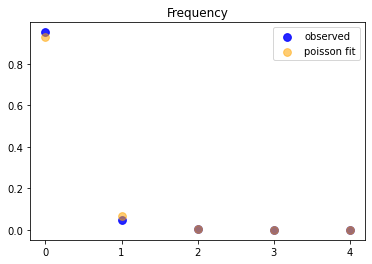

In [3]:
# plt.subplots(figsize=(10, 7))
df_plot = (
    df.loc[:, ['ClaimNb', 'Exposure']].groupby('ClaimNb').sum()
    .assign(Frequency_Observed = lambda x: x.Exposure / df['Exposure'].sum())
)
mean = df['ClaimNb'].sum() / df['Exposure'].sum()

x = range(5)
plt.scatter(x, df_plot['Frequency_Observed'].values, color="blue", alpha=0.85, s=60, label='observed')
plt.scatter(x, scipy.stats.poisson.pmf(x, mean), color="orange", alpha=0.55, s=60, label="poisson fit")
plt.xticks(x)
plt.legend()
plt.title("Frequency");

This is a strong confirmation for the use of a Poisson when fitting!


### 2.2 Train and test frequency GLM

Now, we start fitting our model. We use claims frequency = claim number/exposure as our outcome variable. We then divide the dataset into training set and test set with a 9:1 random split.

Also, notice that we do not one hot encode our columns. Rather, we take advantage of `glum`'s integration with `tabmat`, which allows us to pass in categorical columns directly! `tabmat` will handle the encoding for us and even includes a handful of helpful matrix operation optimizations. We use the `Categorizer` from [dask_ml](https://ml.dask.org/modules/generated/dask_ml.preprocessing.Categorizer.html) to set our categorical columns as categorical dtypes and to ensure that the categories align in fitting and predicting.

In [4]:
z = df['ClaimNb'].values
weight = df['Exposure'].values
y = z / weight # claims frequency

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train, test = next(ss.split(y))

categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]
predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

X_train_p = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_p = glm_categorizer.transform(df[predictors].iloc[test])
y_train_p, y_test_p = y[train], y[test]
w_train_p, w_test_p = weight[train], weight[test]
z_train_p, z_test_p = z[train], z[test]

Now, we define our GLM using the `GeneralizedLinearRegressor` class from `glum`.

- `family='poisson'`: creates a Poisson regressor
- `alpha_search=True`: tells the GLM to search along the regularization path for the best alpha
- `l1_ratio = 1` tells the GLM to only use l1 penalty (not l2). `l1_ratio` is the elastic net mixing parameter. For ``l1_ratio = 0``, the penalty is an L2 penalty. ``For l1_ratio = 1``, it is an L1 penalty.  For ``0 < l1_ratio < 1``, the penalty is a combination of L1 and L2.

See the `GeneralizedLinearRegressor` class [API documentation](https://glum.readthedocs.io/en/latest/api/modules.html) for more details.

*Note*: `glum` also supported a cross validation model GeneralizedLinearRegressorCV. However, because cross validation requires fitting many models, it is much slower and we don’t demonstrate it in this tutorial.

In [5]:
f_glm1 = GeneralizedLinearRegressor(family='poisson', alpha_search=True, l1_ratio=1, fit_intercept=True)

f_glm1.fit(
    X_train_p,
    y_train_p,
    sample_weight=w_train_p
);

pd.DataFrame({'coefficient': np.concatenate(([f_glm1.intercept_], f_glm1.coef_))},
             index=['intercept'] + f_glm1.feature_names_).T

,intercept,VehBrand__B1,VehBrand__B10,VehBrand__B11,VehBrand__B12,VehBrand__B13,VehBrand__B14,VehBrand__B2,VehBrand__B3,VehBrand__B4,...,VehAge__1,VehAge__2,VehPower__4,VehPower__5,VehPower__6,VehPower__7,VehPower__8,VehPower__9,BonusMalus,Density
coefficient,-4.269268,-0.003721,-0.010846,0.138466,-0.259298,0.0,-0.110712,-0.003604,0.044075,0.0,...,0.045494,-0.139428,-0.070054,-0.028142,0.0,0.0,0.016531,0.164711,0.026764,0.000004


To measure our model's test and train performance, we use the deviance function for the Poisson family. We can get the total deviance function directly from `glum`'s distribution classes and divide it by the sum of our sample weight.

*Note*: a Poisson distribution is equivalent to a Tweedie distribution with power = 1.

In [6]:
PoissonDist = TweedieDistribution(1)
print('training loss f_glm1: {}'.format(
    PoissonDist.deviance(y_train_p, f_glm1.predict(X_train_p), sample_weight=w_train_p)/np.sum(w_train_p)
))

print('test loss f_glm1: {}'.format(
      PoissonDist.deviance(y_test_p, f_glm1.predict(X_test_p), sample_weight=w_test_p)/np.sum(w_test_p)))

training loss f_glm1: 0.45704947333555146
test loss f_glm1: 0.45793061314157685


A GLM with canonical link function (Normal - identity, Poisson - log, Gamma - 1/x, Binomial - logit) with an intercept term has the so called **balance property**. Neglecting small deviations due to an imperfect fit, on the training sample the results satisfy the equality:
$$\sum_{i \in training} w_i y_i = \sum_{i \in training} w_i \hat{\mu}_i$$
As expected, this property holds in our real data:

In [7]:
# balance property of GLM with canonical link, like log-link for Poisson:
z_train_p.sum(), (f_glm1.predict(X_train_p) * w_train_p).sum()

(23785, 23785.198509368805)

## 3. Severity GLM - Gamma distribution<a class="anchor"></a>
[back to Table of Contents](#Table-of-Contents)

Now, we fit a GLM for the severity with the same features as the frequency model.
The severity $y$ is the average claim size.
We define:

- $z$: total claim amount, single claims cut at 100,000
- $w$: number of claims (with positive claim amount!)
- $y = \frac{z}{w}$: severity

### 3.1 Why Gamma distributions
The severity $y$ is a positive, real number, $y \in (0, \infty)$. Theoretically, especially for liability claims, one could have arbitrary large numbers&mdash;very unlikely but possible. A very simple distribution for this range is an Exponential distribution, or its generalization, a Gamma distribution $y \sim Gamma$. In the insurance industry, it is well known that the severity might be skewed by a few very large losses. It's common to model these tail losses separately so here we cut out claims larger than 100,000 to focus on modeling small and moderate claims.

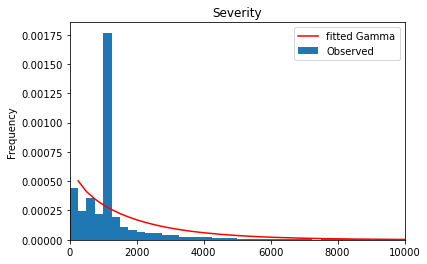

In [8]:
df_plot = (
    df.loc[:, ['ClaimAmountCut', 'ClaimNb']]
    .query('ClaimNb > 0')
    .assign(Severity_Observed = lambda x: x['ClaimAmountCut'] / df['ClaimNb'])
)

df_plot['Severity_Observed'].plot.hist(bins=400, density=True, label='Observed', )

x = np.linspace(0, 1e5, num=400)
plt.plot(x,
         scipy.stats.gamma.pdf(x, *scipy.stats.gamma.fit(df_plot['Severity_Observed'], floc=0)),
         'r-', label='fitted Gamma')
plt.legend()
plt.title("Severity");
plt.xlim(left=0, right = 1e4);
#plt.xticks(x);

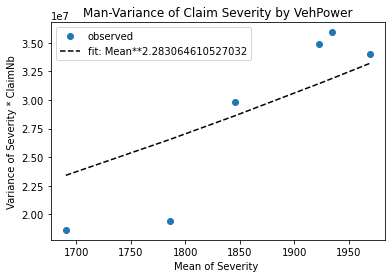

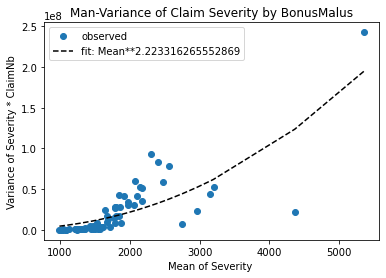

In [9]:
# Check mean-variance relationship for Gamma: Var[Y] = E[Y]^2 / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]^s/Exposure
# Note: We group by VehPower and BonusMalus in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    x_sev = x['Sev']
    x_cnb = x['ClaimNb']
    n = x_sev.shape[0]
    names = {
        'Sev_mean': np.average(x_sev, sample_weight=x_cnb),
        'Sev_var': 1/(n-1) * np.sum((x_cnb/np.sum(x_cnb)) * (x_sev-np.average(x_sev, sample_weight=x_cnb))**2),
        'ClaimNb_sum': x_cnb.sum()
    }
    return pd.Series(names, index=['Sev_mean', 'Sev_var', 'ClaimNb_sum'])

for col in ['VehPower', 'BonusMalus']:
    claims = df.groupby(col)['ClaimNb'].sum()
    df_plot = (df.loc[df[col].isin(claims[claims >= 4].index), :]
               .query('ClaimNb > 0')
               .assign(Sev = lambda x: x['ClaimAmountCut']/x['ClaimNb'])
               .groupby(col)
               .apply(my_agg)
              )

    plt.plot(df_plot['Sev_mean'], df_plot['Sev_var'] * df_plot['ClaimNb_sum'], '.',
             markersize=12, label='observed')

    # fit: mean**p/claims
    p = optimize.curve_fit(lambda x, p: np.power(x, p),
                           df_plot['Sev_mean'].values,
                           df_plot['Sev_var'] * df_plot['ClaimNb_sum'],
                           p0 = [2])[0][0]
    df_fit = pd.DataFrame({'x': df_plot['Sev_mean'],
                           'y': np.power(df_plot['Sev_mean'], p)})
    df_fit = df_fit.sort_values('x')

    plt.plot(df_fit.x, df_fit.y,
             'k--', label='fit: Mean**{}'.format(p))
    plt.xlabel('Mean of Severity ')
    plt.ylabel('Variance of Severity * ClaimNb')
    plt.legend()
    plt.title('Man-Variance of Claim Severity by {}'.format(col))
    plt.show()

Great! A Gamma distribution seems to be an empirically reasonable assumption for this dataset.


*Hint*: If Y were normal distributed, one should see a horizontal line, because $Var[Y] = constant/Exposure$
       and the fit should give $p \approx 0$.

### 3.2 Severity GLM with train and test data
We fit a GLM for the severity with the same features as the frequency model. We use the same categorizer as before.

*Note*:

- We filter out ClaimAmount == 0. The severity problem is to model claim amounts conditional on a claim having already been submitted. It seems reasonable to treat a claim of zero as equivalent to no claim at all. Additionally, zero is not included in the open interval $(0, \infty)$ support of the Gamma distribution.
- We use ClaimNb as sample weights.
- We use the same split in train and test data such that we can predict the final claim amount on the test set as the product of our Poisson claim number and Gamma claim severity GLMs.

In [10]:
idx = df['ClaimAmountCut'].values > 0

z = df['ClaimAmountCut'].values
weight = df['ClaimNb'].values
# y = claims severity
y = np.zeros_like(z)  # zeros will never be used
y[idx] = z[idx] / weight[idx]

# we also need to represent train and test as boolean indices
itrain = np.zeros(y.shape, dtype='bool')
itest = np.zeros(y.shape, dtype='bool')
itrain[train] = True
itest[test] = True
# simplify life
itrain = idx & itrain
itest = idx & itest

X_train_g = glm_categorizer.fit_transform(df[predictors].iloc[itrain])
X_test_g = glm_categorizer.transform(df[predictors].iloc[itest])
y_train_g, y_test_g = y[itrain], y[itest]
w_train_g, w_test_g = weight[itrain], weight[itest]
z_train_g, z_test_g = z[itrain], z[itest]

We fit our model with the same parameters before, but of course, this time we use `family=gamma`.

In [11]:
s_glm1 = GeneralizedLinearRegressor(family='gamma', alpha_search=True, l1_ratio=1, fit_intercept=True)
s_glm1.fit(X_train_g, y_train_g, sample_weight=weight[itrain])

pd.DataFrame({'coefficient': np.concatenate(([s_glm1.intercept_], s_glm1.coef_))},
             index=['intercept'] + s_glm1.feature_names_).T

,intercept,VehBrand__B1,VehBrand__B10,VehBrand__B11,VehBrand__B12,VehBrand__B13,VehBrand__B14,VehBrand__B2,VehBrand__B3,VehBrand__B4,...,VehAge__1,VehAge__2,VehPower__4,VehPower__5,VehPower__6,VehPower__7,VehPower__8,VehPower__9,BonusMalus,Density
coefficient,7.3389,-0.034591,0.040528,0.13116,0.035838,0.100753,-0.073995,-0.033196,0.0,0.049078,...,0.0,-0.024827,-0.009537,-0.089972,0.071376,0.009361,-0.042491,0.051636,0.002365,-0.000001


Again, we measure performance with the deviance of the distribution. We also compare against the simple arithmetic mean and include the mean absolute error to help understand the actual scale of our results.

*Note*: a Gamma distribution is equivalent to a Tweedie distribution with power = 2.

In [26]:
GammaDist = TweedieDistribution(2)
print('training loss (deviance) s_glm1:     {}'.format(
    GammaDist.deviance(
        y_train_g, s_glm1.predict(X_train_g), sample_weight=w_train_g
    )/np.sum(w_train_g)
))
print('training mean absolute error s_glm1: {}'.format(
    mean_absolute_error(y_train_g, s_glm1.predict(X_train_g))
))

print('\ntesting loss s_glm1 (deviance):      {}'.format(
    GammaDist.deviance(
        y_test_g, s_glm1.predict(X_test_g), sample_weight=w_test_g
    )/np.sum(w_test_g)
))
print('testing mean absolute error s_glm1:  {}'.format(
    mean_absolute_error(y_test_g, s_glm1.predict(X_test_g))
))

print('\ntesting loss Mean (deviance):        {}'.format(
    GammaDist.deviance(
        y_test_g, np.average(z_train_g, sample_weight=w_train_g)*np.ones_like(z_test_g), sample_weight=w_test_g
    )/np.sum(w_test_g)
))
print('testing mean absolute error Mean:    {}'.format(
    mean_absolute_error(y_test_g, np.average(z_train_g, sample_weight=w_train_g)*np.ones_like(z_test_g))
))

training loss (deviance) s_glm1:     1.29010461534461
training mean absolute error s_glm1: 1566.1785138646032

testing loss s_glm1 (deviance):      1.2975718597070154
testing mean absolute error s_glm1:  1504.4458958597086

testing loss Mean (deviance):        1.3115309309577132
testing mean absolute error Mean:    1689.205530922944


Even though the deviance improvement seems small, the improvement in mean absolute error is not! (In the insurance world, this will make a significant difference when aggregated over all claims).

### 3.3 Combined frequency and severity results

We put together the prediction of frequency and severity to get the predictions of the total claim amount per policy.

In [13]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * f_glm1.predict(X_train_p) * s_glm1.predict(X_train_p)))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * f_glm1.predict(X_test_p) * s_glm1.predict(X_test_p)))
     )

Total claim amount on train set, observed = 44594644.68, predicted = 44549152.42247057
Total claim amount on test set, observed = 4707551.37, predicted = 4946960.354743531


## 4. Combined GLM - Tweedie distribution<a class="anchor"></a>
[back to Table of Contents](#Table-of-Contents)

Finally, to demonstrate an alternate approach to the combined frequency severity model, we show how we can model pure premium directly using a Tweedie regressor. Any Tweedie distribution with power $p\in(1,2)$ is known as [compound Poisson Gamma distribution](https://en.wikipedia.org/wiki/Compound_Poisson_distribution#Compound_Poisson_Gamma_distribution)

In [14]:
weight = df['Exposure'].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]
y = df["PurePremium"]

X_train_t = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_t = glm_categorizer.transform(df[predictors].iloc[test])
y_train_t, y_test_t = y.iloc[train], y.iloc[test]
w_train_t, w_test_t = weight[train], weight[test]

For now, we just arbitrarily select 1.5 as the power parameter for our Tweedie model. However for a better fit we could include the power parameter in the optimization/fitting process, possibly via a simple grid search.

*Note*: notice how we pass a `TweedieDistribution` object in directly for the family parameter. While `glum` supports strings for common families, it is also possible to pass in a glum distribution directly.

In [15]:
TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, alpha_search=True, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)


pd.DataFrame({'coefficient': np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
             index=['intercept'] + t_glm1.feature_names_).T

,intercept,VehBrand__B1,VehBrand__B10,VehBrand__B11,VehBrand__B12,VehBrand__B13,VehBrand__B14,VehBrand__B2,VehBrand__B3,VehBrand__B4,...,VehAge__1,VehAge__2,VehPower__4,VehPower__5,VehPower__6,VehPower__7,VehPower__8,VehPower__9,BonusMalus,Density
coefficient,2.88667,-0.064157,0.0,0.231868,-0.211061,0.054979,-0.270346,-0.071453,0.00291,0.059324,...,0.008117,-0.229906,-0.111796,-0.123388,0.060757,0.005179,-0.021832,0.208158,0.032508,0.000002


Again, we use the distribution's deviance to measure model performance

In [16]:
print('training loss s_glm1: {}'.format(
    TweedieDist.deviance(y_train_t, t_glm1.predict(X_train_t), sample_weight=w_train_t)/np.sum(w_train_t)))

print('testing loss s_glm1:  {}'.format(
    TweedieDist.deviance(y_test_t, t_glm1.predict(X_test_t), sample_weight=w_test_t)/np.sum(w_test_t)))

training loss s_glm1: 73.91371104577475
testing loss s_glm1:  72.35318912371723


Finally, we again show the total predicted vs. true claim amount on the training and test set

In [17]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * t_glm1.predict(X_train_p)))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * t_glm1.predict(X_test_p)))
     )

Total claim amount on train set, observed = 44594644.68, predicted = 45027861.66007367
Total claim amount on test set, observed = 4707551.37, predicted = 4999381.03386664


In terms of the combined proximity to the true total claim amounts, the frequency severity model performed a bit better than Tweedie model. However, both approaches ultimately prove to be effective.